# Исследование надёжности заёмщиков

## Введение
Данный проект представляет из себя анализ статистистических данных о платёжеспособности клиентов банка.

Цель проведения исследования: определить параметры, влияющие на факт возврата кредита в срок, для построения модели скоринга банка.

В ходе работы планируется изучить предоставленные данные, рассмотреть их на предмет ошибок и неточностей, которые могут помешать анализу, исправить их и далее - проанализировать влияние разных факторов на факт возврата кредита в срок. Более подробно шаги представлены в оглавлении ниже.



## Оглавление 
1. [Общая информация о данных](#step1)
2. [Предобработка данных](#step2)
    1. [Обработка пропусков](#pre1)
    2. [Замена типа данных](#pre2)
    3. [Обработка дубликатов](#pre3)
    4. [Лемматизация](#pre4)
    5. [Категоризация данных](#pre5)  
3. [Анализ зависимости возврата кредита в срок от разных параметров](#step3)
4. [Общий вывод](#step4)



### 1. Общая информация.  <a name="step1"></a>

In [1]:
import pandas as pd
data = pd.read_csv('/datasets/data.csv')
data 

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


In [2]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


### Вывод
Таблица представляет из себя данные по 21525 клиентам. 
Столбцы названы корректно. Однако интересно, что нет столбца, отражающего User ID или какое-то другое наименование объекта (хоть и абстрактное) - ни ФИО, ни номера.
Для задач исследования (выяснения, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок) по поверхностной оценке данных достаточно.
При этом они представлены довольно полно: по всем столбцам, кроме трудового стажа и ежемесячного дохода, заполнены все 21525 ячеек, причем числовые данные уже заданы в нужном формате.
Из явных недочетов, которые видны на первый взгляд:
- по трудовому стажу и ежемесячному доходу по 2174 клиентам представлены нулевые данные, предположительно, речь идет о студентах (нужно проверить);
- по трудовому стажу некоторые данные представлены в виде отрицательных чисел, вероятно, ошибка в записи данных (технологическая ошибка) - надо привести к положительным величинам;
- в столбце education данные представлены словами в разном регистре(надо унифицировать);
- в столбце purpose - цель кредита - есть записи, которые похожи по смыслу, но различаются по написанию ("покупка жилья" и "операции с жильем", "дополнительное образование" и "образование", "сыграть свадьбу" и "на проведение свадьбы", наверняка есть и другие) - предположительно, было бы удобно сделать классификатор целей и вывести его отдельным столбцом.

### 2. Предобработка данных <a name="step2"></a>

Проверим предположение о том, что все, кто не имеют стажа и ежемесячный доход - это студенты

In [3]:
data['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64

Гипотеза не подтвердилась, студент оказался всего 1, значит будем искать другой вараинт, откуда возникли пустые значения.

Для начала проверим по всем остальным столбцам, нет ли там экстраординарных значений (например, нулевой возраст или доход).
Про стаж мы уже знаем, что там есть отрицательные значения, которых быть не должно.

In [4]:
data['dob_years'].value_counts() #обнаружились значения 0, которых быть не должно. Их всего 101. Удалим эти строки из таблицы, чтобы они нас не путали.
data = data[data.dob_years != 0]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21424 entries, 0 to 21524
Data columns (total 12 columns):
children            21424 non-null int64
days_employed       19260 non-null float64
dob_years           21424 non-null int64
education           21424 non-null object
education_id        21424 non-null int64
family_status       21424 non-null object
family_status_id    21424 non-null int64
gender              21424 non-null object
income_type         21424 non-null object
debt                21424 non-null int64
total_income        19260 non-null float64
purpose             21424 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.1+ MB


In [5]:
data['education'].value_counts() #здесь надо будет поработать с регистром

среднее                13691
высшее                  4686
СРЕДНЕЕ                  770
Среднее                  708
неоконченное высшее      666
ВЫСШЕЕ                   273
Высшее                   266
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

In [6]:
data['family_status'].value_counts() #тоже лучше привести к единому регисту

женат / замужем          12331
гражданский брак          4156
Не женат / не замужем     2797
в разводе                 1185
вдовец / вдова             955
Name: family_status, dtype: int64

In [7]:
data['gender'].value_counts() #есть 1 загадочный XNA, лучше тоже его удалить

F      14164
M       7259
XNA        1
Name: gender, dtype: int64

In [8]:
data = data[data.gender != 'XNA']
data['gender'].value_counts()

F    14164
M     7259
Name: gender, dtype: int64

In [9]:
data['purpose'].value_counts()

свадьба                                   792
на проведение свадьбы                     773
сыграть свадьбу                           769
операции с недвижимостью                  673
покупка коммерческой недвижимости         661
покупка жилья для сдачи                   651
операции с коммерческой недвижимостью     649
операции с жильем                         647
жилье                                     641
покупка жилья                             641
покупка жилья для семьи                   640
строительство собственной недвижимости    633
недвижимость                              630
операции со своей недвижимостью           630
строительство жилой недвижимости          623
строительство недвижимости                620
покупка недвижимости                      620
покупка своего жилья                      619
ремонт жилью                              610
покупка жилой недвижимости                604
на покупку своего автомобиля              502
заняться высшим образованием      

In [10]:
data['children'].value_counts() #и здесь выпадающие значения: -1 и 20. Строки со значением 20 удалим, т.к. если это описка, то не ясно, имелось в виду: 0 или 2. А вот -1 можно оставить, переделав на 1

 0     14079
 1      4802
 2      2042
 3       328
 20       75
-1        47
 4        41
 5         9
Name: children, dtype: int64

In [11]:
data = data[data.children != 20]
data['children'].value_counts()

 0    14079
 1     4802
 2     2042
 3      328
-1       47
 4       41
 5        9
Name: children, dtype: int64

Осталось поменять имеющиеся отрицательные значения в столбцах days_employed и children

In [12]:
data['children'] = abs(data['children'])
data['children'].value_counts()
data['days_employed'] = abs(data['days_employed'])
data['total_income'] = abs(data['total_income']) #на всякий случай доход тоже преобразуем в положительные значения

print(data.info())

data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21348 entries, 0 to 21524
Data columns (total 12 columns):
children            21348 non-null int64
days_employed       19193 non-null float64
dob_years           21348 non-null int64
education           21348 non-null object
education_id        21348 non-null int64
family_status       21348 non-null object
family_status_id    21348 non-null int64
gender              21348 non-null object
income_type         21348 non-null object
debt                21348 non-null int64
total_income        19193 non-null float64
purpose             21348 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.1+ MB
None


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


### Обработка пропусков <a name="pre1"></a>

Оба столбца с нулевыми значениями содержат количественные переменные. Общее число пропусков составляет больше 10% от всей выборки, поэтому просто удалить их будет неправильно
Т.к. кол-во пропусков в обоих столбцах совпадает, то предположим, что NaN в трудовом стаже и ежемесясном доходе находитсся в одних и тех же строках.

In [13]:
data_null = data[(data['days_employed'].isnull()) & (data['total_income'].isnull())] 
print(data_null.head())
data_null.info() 

    children  days_employed  dob_years education  education_id  \
12         0            NaN         65   среднее             1   
26         0            NaN         41   среднее             1   
29         0            NaN         63   среднее             1   
41         0            NaN         50   среднее             1   
55         0            NaN         54   среднее             1   

            family_status  family_status_id gender  income_type  debt  \
12       гражданский брак                 1      M    пенсионер     0   
26        женат / замужем                 0      M  госслужащий     0   
29  Не женат / не замужем                 4      F    пенсионер     0   
41        женат / замужем                 0      F  госслужащий     0   
55       гражданский брак                 1      F    пенсионер     1   

    total_income                           purpose  
12           NaN                   сыграть свадьбу  
26           NaN                       образование  
29   

Предположение подтвердилось. Вероятно, эти люди не смогли или не захотели предоставить данные о своем трудовом стаже. Либо они работали неофициально и у них нет подтверждения с места работы. Другое предположение: эти данные просто были перенесены неверно, т.к., вероятно, чтобы получить кредит, какие-то документы о доходах должны были быть предоставлены.  

Среди "нулевых" есть представители разных типов занятости. Предположим, что уровень получаемого дохода зависит от типа занятости.
Стаж работы скорее зависит от возраста, но брать каждый возраст в отдельности - нецелесообразно, разобьем возраста на группы.
В каждом случае определим медианное значение, на которое будем заменять NaNы (брать среднее опасно, т.к. могут быть отклонения в данных, которые исказят смысл).

In [14]:
data['total_income'] = data['total_income'].fillna(data.groupby('income_type')['total_income'].transform('median'))
print(data[data['days_employed'].isnull()].head(10))

    children  days_employed  dob_years education  education_id  \
12         0            NaN         65   среднее             1   
26         0            NaN         41   среднее             1   
29         0            NaN         63   среднее             1   
41         0            NaN         50   среднее             1   
55         0            NaN         54   среднее             1   
65         0            NaN         21   среднее             1   
67         0            NaN         52    высшее             0   
72         1            NaN         32    высшее             0   
82         2            NaN         50    высшее             0   
83         0            NaN         52   среднее             1   

            family_status  family_status_id gender  income_type  debt  \
12       гражданский брак                 1      M    пенсионер     0   
26        женат / замужем                 0      M  госслужащий     0   
29  Не женат / не замужем                 4      F    

In [15]:
#Зададим функцию для группировки по возрасту. Как мы посмотрели, минимальный возраст - 17, максимальный - 75
def dob_years_category(age):
    if  17 <= age <= 25:
        return '17-25'
    elif 25 < age <= 35:
        return '26-35'
    elif 35 < age <= 45:
        return '36-45'
    elif 45 < age <= 55:
        return '46-55'
    elif age > 55:
        return '>56'
dob_years_category(30) #проверили работу функции
data['dob_years_category'] = data['dob_years'].apply(dob_years_category)
print(data.head())

   children  days_employed  dob_years education  education_id  \
0         1    8437.673028         42    высшее             0   
1         1    4024.803754         36   среднее             1   
2         0    5623.422610         33   Среднее             1   
3         3    4124.747207         32   среднее             1   
4         0  340266.072047         53   среднее             1   

      family_status  family_status_id gender income_type  debt   total_income  \
0   женат / замужем                 0      F   сотрудник     0  253875.639453   
1   женат / замужем                 0      F   сотрудник     0  112080.014102   
2   женат / замужем                 0      M   сотрудник     0  145885.952297   
3   женат / замужем                 0      M   сотрудник     0  267628.550329   
4  гражданский брак                 1      F   пенсионер     0  158616.077870   

                      purpose dob_years_category  
0               покупка жилья              36-45  
1     приобретение а

In [16]:
data['days_employed'] = data['days_employed'].fillna(data.groupby('dob_years_category')['days_employed'].transform('median'))

print(data.head(5))
print()
print(data.info())

   children  days_employed  dob_years education  education_id  \
0         1    8437.673028         42    высшее             0   
1         1    4024.803754         36   среднее             1   
2         0    5623.422610         33   Среднее             1   
3         3    4124.747207         32   среднее             1   
4         0  340266.072047         53   среднее             1   

      family_status  family_status_id gender income_type  debt   total_income  \
0   женат / замужем                 0      F   сотрудник     0  253875.639453   
1   женат / замужем                 0      F   сотрудник     0  112080.014102   
2   женат / замужем                 0      M   сотрудник     0  145885.952297   
3   женат / замужем                 0      M   сотрудник     0  267628.550329   
4  гражданский брак                 1      F   пенсионер     0  158616.077870   

                      purpose dob_years_category  
0               покупка жилья              36-45  
1     приобретение а

### Вывод

Мы проверили все столбцы на предмет адекватности данных в них, т.к. при поверхностном взгляде на таблицу их можно не увидеть. Были обнаружены и устранены следующие проблемы, касающиеся некорректного внесения данных и появления пропусков:
1. Столбец "Кол-во детей": затерялись ошибочно проставленные значения -1 и 20. Если для -1 скорее всего "-" был поставлен случайно и мы его переделали на "+", то с "20" решили не догадываться (мало ли, имелось в виду 2, 0 или что-то еще), и строки с такими значениями из таблицы были удалены
2. Столбец "Пол": одно выпадающее значение, строка с которым была удалена, т.к. невозможно угадать, какого пола был человек
3. Столбец возраст: по 101 человеку потерялдись данные по возрасту. Здесь можно было попробовать "угадать" возраст, исходя из типа занятости и рабочего стажа, но таких значений всего 101 (менее 0,5% выборки), поэтому ими тоже было решено пожертвовать
4. Столбец "Трудовой стаж": большое кол-во данных было представлено отрицательными числами, вероятно, имеется системная ошибка в записи данной переменной (надо сообщить разработчику!). Отрицательные значения были заменены на положительные.
5. Пропуски количественных данных NaN в столбцах "Трудовой стаж" и "Ежемесячный доход" оказались созависимы: 2174 строки исходной таблицы содержат нулевые значения по обеим колонкам. Они могут возникать по нескольким причинам: вероятно, эти люди не смогли или не захотели предоставить данные о своем трудовом стаже. Либо они работали неофициально и у них нет подтверждения с места работы. Другое предположение: эти данные просто были перенесены неверно, т.к., вероятно, чтобы получить кредит, какие-то документы о доходах должны были быть предоставлены. Чтобы заменить пропуски в ежемесячном доходе посчитаны медианные значения по признаку "тип занятости". Для замены пропусков в столбце "Трудовой стаж" за основу взяты возрастные группы кредиторов - по ним также вычислены медианы. По идее для целей анализа можно было вместо NaN поставить значения No info, чтобы начши медианные значения не повлияли на конечный результат. Но т.к. мы считаем данные для модели скоринга и есть вероятность, что и в дальнейшем к нам будут попадать клиенты без данных о стаже и доходе, а считать по ним вероятность возврата кредита надо, то вычисленные нами значения помогут справиться с задачей.

Итог: исходная таблица очищена от некорректных и нулевых значений.
Общая длина таблицы уменьшилась с 21525 до 21348 строк (что некритично для целей анализа).

### Замена типа данных <a name="pre2"></a>

In [17]:
#В исходных данных количественные данные уже были заданы как количественные переменные, однако нам не удобно и нет необходимости рассматривать зарплату до копеек и мерить трудовой стаж в неровных днях.
#Эти переменные нужно привести к типу integer
data['days_employed'] = data['days_employed'].astype('int')
data['total_income'] = data['total_income'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21348 entries, 0 to 21524
Data columns (total 13 columns):
children              21348 non-null int64
days_employed         21348 non-null int64
dob_years             21348 non-null int64
education             21348 non-null object
education_id          21348 non-null int64
family_status         21348 non-null object
family_status_id      21348 non-null int64
gender                21348 non-null object
income_type           21348 non-null object
debt                  21348 non-null int64
total_income          21348 non-null int64
purpose               21348 non-null object
dob_years_category    21348 non-null object
dtypes: int64(7), object(6)
memory usage: 2.3+ MB


### Вывод

Все переменные типа float заменены на тип integer.
Теперь данные по трудовому стажу и ежемесячному доходу выглядят более адекватно и презентабельно.

### Обработка дубликатов <a name="pre3"></a>

In [18]:
#Сначала разберемся с регистром
data['education'] = data['education'].str.lower()
data['education'].value_counts()

среднее                15110
высшее                  5211
неоконченное высшее      739
начальное                282
ученая степень             6
Name: education, dtype: int64

In [19]:
data['family_status'] = data['family_status'].str.lower()
data['family_status'].value_counts()

женат / замужем          12283
гражданский брак          4143
не женат / не замужем     2788
в разводе                 1183
вдовец / вдова             951
Name: family_status, dtype: int64

In [20]:
#Проверим число дублирующихся строк и избавимся от них
print(data.duplicated().sum())

71


In [22]:
#Проверим, как выглядят дублирующиеся строки
duplicate = list(data.duplicated())
data['duplicates'] = duplicate
data

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,dob_years_category,duplicates
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,36-45,False
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,36-45,False
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,26-35,False
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,26-35,False
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,46-55,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем,36-45,False
21521,0,343937,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем,>56,False
21522,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость,36-45,False
21523,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля,36-45,False


In [23]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21348 entries, 0 to 21524
Data columns (total 14 columns):
children              21348 non-null int64
days_employed         21348 non-null int64
dob_years             21348 non-null int64
education             21348 non-null object
education_id          21348 non-null int64
family_status         21348 non-null object
family_status_id      21348 non-null int64
gender                21348 non-null object
income_type           21348 non-null object
debt                  21348 non-null int64
total_income          21348 non-null int64
purpose               21348 non-null object
dob_years_category    21348 non-null object
duplicates            21348 non-null bool
dtypes: bool(1), int64(7), object(6)
memory usage: 2.3+ MB
None


In [24]:
duplicated_data = data[data['duplicates'] != False]

print(duplicated_data.head(10)) 

      children  days_employed  dob_years education  education_id  \
2849         0           1918         41   среднее             1   
3290         0         347548         58   среднее             1   
4182         1           1352         34    высшее             0   
4851         0         347548         60   среднее             1   
5557         0         347548         58   среднее             1   
6312         0           1352         30   среднее             1   
7808         0         347548         57   среднее             1   
7921         0         347548         64    высшее             0   
7938         0         347548         71   среднее             1   
8583         0         347548         58    высшее             0   

              family_status  family_status_id gender income_type  debt  \
2849        женат / замужем                 0      F   сотрудник     0   
3290       гражданский брак                 1      F   пенсионер     0   
4182       гражданский брак  

Среди строк не обнаружено абсолютных дубликатов. Однако есть "подозрительные" строки, совпадающие до цифры по доходу и по трудовому стажу, но отличающиеся, например, семейным статусом. Желательно выяснить у разработчиков, откуда такие строки взялись и как избежать их появления вновь.

In [25]:
data = data.drop_duplicates().reset_index(drop=True) #используем данный метод, чтобы сразу убрать все дублирующиеся строки
print(data.duplicated().sum())

0


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21343 entries, 0 to 21342
Data columns (total 14 columns):
children              21343 non-null int64
days_employed         21343 non-null int64
dob_years             21343 non-null int64
education             21343 non-null object
education_id          21343 non-null int64
family_status         21343 non-null object
family_status_id      21343 non-null int64
gender                21343 non-null object
income_type           21343 non-null object
debt                  21343 non-null int64
total_income          21343 non-null int64
purpose               21343 non-null object
dob_years_category    21343 non-null object
duplicates            21343 non-null bool
dtypes: bool(1), int64(7), object(6)
memory usage: 2.1+ MB


### Вывод

Мы избавились от 71 дублированной строки (дубли относились к разным строкам), привели данные к единому регистру, в результате чего ушли дубли в столбце "Образование".
Причиной появления задублированных строк скорее всего стала техническая ошибка выгрузки. 
В нашем рабочем датафрейме осталось 21277 строк.

### Лемматизация <a name="pre4"></a>

In [27]:
from pymystem3 import Mystem
m = Mystem() 
data['purpose_lemmas'] = data.purpose.apply(m.lemmatize)
data


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,dob_years_category,duplicates,purpose_lemmas
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,36-45,False,"[покупка, , жилье, \n]"
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,36-45,False,"[приобретение, , автомобиль, \n]"
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,26-35,False,"[покупка, , жилье, \n]"
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,26-35,False,"[дополнительный, , образование, \n]"
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,46-55,False,"[сыграть, , свадьба, \n]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21338,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем,36-45,False,"[операция, , с, , жилье, \n]"
21339,0,343937,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем,>56,False,"[сделка, , с, , автомобиль, \n]"
21340,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость,36-45,False,"[недвижимость, \n]"
21341,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля,36-45,False,"[на, , покупка, , свой, , автомобиль, \n]"


In [28]:
#Посмотрим на целевые категории, чтобы в соответствии с ними затем сделать категоризацию данных
from collections import Counter
Counter(m.lemmatize(' '.join(data['purpose'])))

Counter({'покупка': 5866,
         ' ': 54754,
         'жилье': 4432,
         'приобретение': 460,
         'автомобиль': 4278,
         'дополнительный': 901,
         'образование': 3989,
         'сыграть': 764,
         'свадьба': 2322,
         'операция': 2589,
         'с': 2897,
         'на': 2209,
         'проведение': 767,
         'для': 1289,
         'семья': 639,
         'недвижимость': 6322,
         'коммерческий': 1303,
         'жилой': 1224,
         'строительство': 1869,
         'собственный': 627,
         'подержать': 845,
         'свой': 2224,
         'со': 629,
         'заниматься': 904,
         'сделка': 937,
         'получение': 1308,
         'высокий': 1361,
         'подержанный': 111,
         'профильный': 433,
         'сдача': 650,
         'ремонт': 606,
         '\n': 1})

### Вывод

Выделены леммы для колонки "Цели кредита". Самые часто встречающиеся слова, относящиеся к целям получения кредита: автомобиль, жилье, недвижимость, образование и свадьба.

### Категоризация данных <a name="pre5"></a>

In [29]:
def purpose_category(lemmas):
    if 'автомобиль' in lemmas:
        return 'автомобиль'
    elif 'жилье' in lemmas:
        return 'жилье'
    elif 'образование' in lemmas:
        return 'образование'
    elif 'свадьба' in lemmas:
        return 'свадьба'
    elif 'недвижимость' in lemmas:        
        return 'жилье' # недвижимость и жилье, как правило, одно и то же
    else:
        return 'прочее'
data['purpose_category'] = data['purpose_lemmas'].apply(purpose_category) 
data    

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,dob_years_category,duplicates,purpose_lemmas,purpose_category
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,36-45,False,"[покупка, , жилье, \n]",жилье
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,36-45,False,"[приобретение, , автомобиль, \n]",автомобиль
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,26-35,False,"[покупка, , жилье, \n]",жилье
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,26-35,False,"[дополнительный, , образование, \n]",образование
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,46-55,False,"[сыграть, , свадьба, \n]",свадьба
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21338,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем,36-45,False,"[операция, , с, , жилье, \n]",жилье
21339,0,343937,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем,>56,False,"[сделка, , с, , автомобиль, \n]",автомобиль
21340,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость,36-45,False,"[недвижимость, \n]",жилье
21341,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля,36-45,False,"[на, , покупка, , свой, , автомобиль, \n]",автомобиль


In [30]:
#проверим, сколько значений у нас получилось в каждой из представленных категорий, чтобы понять, все ли основные категории мы учли и нет ли у нас слишком много кредиторов, которые попали в "прочее"
data['purpose_category'].value_counts()  

жилье          10754
автомобиль      4278
образование     3989
свадьба         2322
Name: purpose_category, dtype: int64

### Вывод

Люди берут больше всего кредитов на покупку жилья (более, чем в 2 раза эта цель по числу упоминаний превышает любую другую). Интересно, что по сути выявлено всего 4 основных направления целей кредитования: жилье, автомобиль, образование и свадьба. Нет ожидаемых категорий "отпуск", "лечение", "развитие бизнеса" и т.д.

### Шаг 3. Ответьте на вопросы <a name="step3"></a>

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [31]:
data.groupby('children')['debt'].agg(['count','mean'])
#Строим сводную таблицу с 2 столбцами: кол-во и среднее. Кол-во - чтобы не делать ошибочных выводов о слишком малочисленных группах.
#Среднее для поля "Выплата долга" со значениями 0 и 1 показывает долю тех, кто не вернул кредит.

,count,mean
children,,
0,14074,0.075174
1,4849,0.091153
2,2042,0.095005
3,328,0.082317
4,41,0.097561
5,9,0.000000


In [32]:
#Построим pivot
data_pivot_children = data.pivot_table(index=['children'], columns='debt', values='gender', aggfunc='count')
data_pivot_children

debt,0,1
children,,
0,13016.0,1058.0
1,4407.0,442.0
2,1848.0,194.0
3,301.0,27.0
4,37.0,4.0
5,9.0,NaN


### Вывод

Наблюдается зависимость между количеством детей и возвратом кредита в срок.
Кредиторы без детей в среднем возвращают кредиты чаще, задолженность наблюдается лишь в 7,5% случаев, с детьми - реже (должники - от 8,2% до 9,7%). 
Вероятно, это связано с бОльшими сложностями финансового планирования при появлении у людей детей. Когда человек ответсвенен только за себя, распределить деньги по разным потребностям в целом немного проще.
Интересно также выпадающее значение для тех, кто имеет 5 детей: кредит вернули все. Однако эта группа очень малочисленна (всего 9 человек), поэтому делать по ним вывод некорректно.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [33]:
data.groupby('family_status')['debt'].agg(['count','mean'])

,count,mean
family_status,,
в разводе,1183,0.071006
вдовец / вдова,951,0.065195
гражданский брак,4140,0.092512
женат / замужем,12281,0.075238
не женат / не замужем,2788,0.097561


In [34]:
data_pivot_family = data.pivot_table(index=['family_status'], columns='debt', values='gender', aggfunc='count')
data_pivot_family

debt,0,1
family_status,,
в разводе,1099,84
вдовец / вдова,889,62
гражданский брак,3757,383
женат / замужем,11357,924
не женат / не замужем,2516,272


### Вывод

Наблюдается зависимость между семейным статусом и возвратом кредита в срок. Самые "безответственные" - не женатые и люди, состоящие в гражданском браке. Видимо, отсутствие официально зарегистрированного брака влияет на общую "собранность" людей: они могут не рассчитать выплаты + им не на кого надеяться в случае возникших трудностей. Обе эти категории не возвращают кредиты с вероятностью 9,3-9,7%.
Самые "благонадёжные" - вдовы (вероятность невозврата 6,5%) - скорее всего, это в среднем более зрелые люди, с более устоявшимся финансовым положением, потеря супруга повлияла на их способность рассчитывать свои возможности.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [35]:
#Разделим значения дохода на 10 равных по кол-ву попадающих в них наблюдений групп
data['total_income_category'] = pd.qcut(data['total_income'],10)
data.groupby('total_income_category')['debt'].agg(['count','mean'])

,count,mean
total_income_category,,
"(20666.999, 78805.6]",2135,0.074005
"(78805.6, 98623.6]",2134,0.087160
"(98623.6, 116191.6]",2134,0.082943
"(116191.6, 132157.4]",2134,0.083411
"(132157.4, 142601.0]",2275,0.089670
"(142601.0, 161158.0]",1995,0.083709
"(161158.0, 179425.0]",2133,0.082513
"(179425.0, 214163.0]",2134,0.083411
"(214163.0, 269685.0]",2134,0.070759


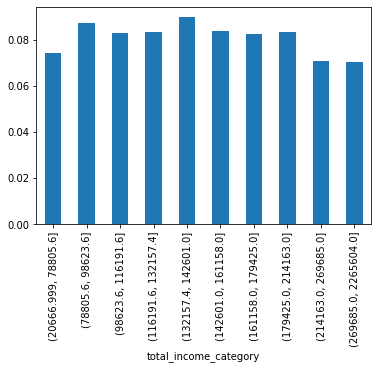

In [36]:
#по цифрам сложно увидеть зависимость, построим график
data.groupby('total_income_category')['debt'].mean().plot(kind='bar')

Довольно сложно понять границы уровней дохода населения для отнесения их к бедным, средним или богатым.
Если смотреть на данные Росстата, то бедные - те, кто получает меньше МРОТ, т.е. 12 130 руб. (предполагаем, что предоставленные нам данные - это месячный доход в рублях РФ). 
Однако в нашем датасете минимальный уровень дохода - 20667 руб.
Тогда в любом случае нам придется в данной категоризации опираться на субъективную оценку.
С учетом предоставленных нам данных предположим, что:
- бедные получают до 75 тыс. руб.
- средние - от 75 до 200 тыс. руб.
- богатые - более 200 тыс. руб.
Тогда заведем новый столбец с категориями для обозначения этого параметра

In [37]:
def total_income_cat(income):
    if income < 75000:
        return 'бедный'
    elif 75000 <= income < 200000:
        return 'средний'
    elif income >= 200000:
        return 'богатый'
data['total_income_cat'] = data['total_income'].apply(total_income_cat) 
data    

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,dob_years_category,duplicates,purpose_lemmas,purpose_category,total_income_category,total_income_cat
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,36-45,False,"[покупка, , жилье, \n]",жилье,"(214163.0, 269685.0]",богатый
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,36-45,False,"[приобретение, , автомобиль, \n]",автомобиль,"(98623.6, 116191.6]",средний
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,26-35,False,"[покупка, , жилье, \n]",жилье,"(142601.0, 161158.0]",средний
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,26-35,False,"[дополнительный, , образование, \n]",образование,"(214163.0, 269685.0]",богатый
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,46-55,False,"[сыграть, , свадьба, \n]",свадьба,"(142601.0, 161158.0]",средний
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21338,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем,36-45,False,"[операция, , с, , жилье, \n]",жилье,"(214163.0, 269685.0]",богатый
21339,0,343937,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем,>56,False,"[сделка, , с, , автомобиль, \n]",автомобиль,"(142601.0, 161158.0]",средний
21340,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость,36-45,False,"[недвижимость, \n]",жилье,"(78805.6, 98623.6]",средний
21341,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля,36-45,False,"[на, , покупка, , свой, , автомобиль, \n]",автомобиль,"(214163.0, 269685.0]",богатый


In [38]:
data.groupby('total_income_cat')['debt'].agg(['count','mean'])

,count,mean
total_income_cat,,
бедный,1850,0.073514
богатый,5020,0.070717
средний,14473,0.085262


In [39]:
data_pivot_income = data.pivot_table(index=['total_income_cat'], columns='debt', values='gender', aggfunc='count')
data_pivot_income

debt,0,1
total_income_cat,,
бедный,1714,136
богатый,4665,355
средний,13239,1234


### Вывод

Сложно сделать однозначный вывод о влиянии уровня дохода на возвращаемость кредитов в срок. Интересно, что наблюдается чуть меньший процент неуплаты по людям с самым маленьким и с самым большим доходом: на уровне 7,0-7,3%. По остальным группам процент плюс-минус похож: от 8,3% до 9,0%. Таким образом нет разницы, бедный или богатый приходит за кредитом: практически с одинаковой вероятностью он деньги не вернет.
То есть учитывать данный фактор при построении модели скоринга не стоит.

- Как разные цели кредита влияют на его возврат в срок?

In [40]:
data.groupby('purpose_category')['debt'].agg(['count','mean'])

,count,mean
purpose_category,,
автомобиль,4278,0.093034
жилье,10754,0.072252
образование,3989,0.092504
свадьба,2322,0.077950


In [41]:
data_pivot_purpose = data.pivot_table(index=['purpose_category'], columns='debt', values='gender', aggfunc='count')
data_pivot_purpose

debt,0,1
purpose_category,,
автомобиль,3880,398
жилье,9977,777
образование,3620,369
свадьба,2141,181


### Вывод

Как мы уже обнаружили ранее, больше всего кредитов люди берут на покупку жилья. При этом и возвращается в срок такой кредит чаще всего: только в 7,2% случаев происходит невозврат. Менее ответственные - покупатели автомобилей и те, кто планируют оплатить образование (9,3%). Вероятно, решение о покупке квартиры люди принимают более взвешенно, такая покупка планируется заранее и деньги на нее в бюджет также закладываются заранее.
Решение о приобретении автомобиля и получении образования носят другой характер. У машины более короткий срок службы и через несколько лет человек уже хочет ее продать или поменять, поэтому, вероятно "забивает" на кредит. Образование тоже не обязательно завершается в срок, могут меняться планы, связанные с ним, и поэтому люди не торопятся вернуть взятые взаймы деньги.

### Шаг 4. Общий вывод <a name="step4"></a>

Исходная статистика о платёжеспособности клиентов, по которой необходимо было провести анализ, потребовала предобработки. Были скорректированы артефакты: отрицательные значения количественных переменных переведены в положительные, изменен тип данных в количественных переменных на целочисленный, удалены дубликаты, заменены пропуски. Данные были категоризированы на основе цели получения кредита через лемматизацию.
По итогам анализа обнаружилось, что самые надёжные заёмщики - вдовы без детей, желающие приобрести жилье. Самые же "безответсветные" - люди, имеющие детей, свободные или находящиеся в гражданском браке, берущие кредит на покупку автомобиля или на оплату образования. При этом, как ни странно, уровень дохода напрямую не влияет на возврат кредита в срок: как среди бедных, так и среди богатых есть должники.